# Large language models (LLMs): Part II

Author: Archit Vasan , including materials on LLMs by Varuni Sastri, and discussion/editorial work by Taylor Childers, Carlo Graziani, Bethany Lusch, and Venkat Vishwanath (Argonne)

Inspiration from the blog posts "The Illustrated Transformer" and "The Illustrated GPT2" by Jay Alammar, highly recommended reading.

Before you begin, make sure that you have your environment set up and your repo refreshed, as described in previous lessons, and reviewed in the accompanying 'Readme.md' file. Make sure that you select the kernel 'datascience/conda-2023-01-10' at the top-left of the Jupyter notebook.

## Overview
1. Training and inference using Hugging Face
2. Elements of an LLM
3. Attention mechanisms
4. Positional encoding
5. Output layers
6. Training loops

In [ ]:
import os
os.environ["HTTP_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["HTTPS_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["http_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["https_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["ftp_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"

## LLM training and inference using HuggingFace

<img src="https://github.com/lueiyaya/ai-science-training-series-copy-mz/blob/main/05_llm_part2/images/hf-logo-with-title.png?raw=1" alt="Drawing" style="width: 300px;"/>
HuggingFace is a platform and community that provides open-source library tools and resources like pre-trained models and datasets.
Refer to the following links for more information :

https://huggingface.co/docs/hub/index

https://huggingface.co/docs/transformers/en/index

Warning: _Large Language Models are only as good as their training data. They have no ethics, no judgement, or editing ability. We will be using some pretrained models from Hugging Face which used wide samples of internet hosted text. The datasets have not been strictly filtered to restrict all malign content so the generated text may be surprisingly dark or questionable. They do not reflect our core values and are only used for demonstration purposes._

### Inference

We can use the Huggingface pipeline with a pretrained GPT2 model to generate text given a prompt.

In [ ]:
from transformers import AutoTokenizer,AutoModelForCausalLM, AutoConfig
input_text = "My dog really wanted to"
from transformers import pipeline
generator = pipeline("text-generation", model="openai-community/gpt2")
generator(input_text, max_length=20, num_return_sequences=5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'My dog really wanted to tell me everything to my surprise when I came out of it at the end'},
 {'generated_text': 'My dog really wanted to be one. But when he got off the dogs, the whole thing came'},
 {'generated_text': 'My dog really wanted to try it," says Miele.\n\nHabitat\n\n'},
 {'generated_text': 'My dog really wanted to sit on me."\n\nWhat are your thoughts on the new program,'},
 {'generated_text': 'My dog really wanted to have a chat with you." After making her decision to walk away and being'}]

We will cover  evaluation metrics,as well as safe and responsibilities practices when using LLMs in **Session 8**.

### Training

We can also load in our own dataset and train a model with this data as follows:

In [ ]:
! pip3 install -U accelerate
! pip3 install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.27.2
    Uninstalling accelerate-0.27.2:
      Successfully uninstalled accelerate-0.27.2


In [ ]:
# check the package instalment
from transformers.utils import is_accelerate_available
is_accelerate_available()

True

In [ ]:
from transformers import TextDataset,DataCollatorForLanguageModeling

def load_dataset(train_path,test_path,tokenizer):
    train_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=128)
    test_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=128)
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset,test_dataset,data_collator

In [ ]:
from transformers import AutoTokenizer,AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")

train_dataset,test_dataset,data_collator = load_dataset('dataset/train_input.txt','dataset/test_input.txt', tokenizer)

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./gpt2", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    eval_steps = 40, # Number of update steps between two evaluations.
    save_steps=80, # after # steps model is saved
    warmup_steps=50,# number of warmup steps for learning rate scheduler
    prediction_loss_only=True,
    )

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (272065 > 1024). Running this sequence through the model will result in indexing errors


## What is going on below the hood?

There are two components that are "black-boxes" here:
1. The method for tokenization
2. The model that generates novel text.

Carlo Graziani already gave a great explanation of tokenization last week and how this affects embeddings (https://github.com/argonne-lcf/ai-science-training-series/blob/main/04_intro_to_llms/Sequential_Data_Models.ipynb)

Today we will take a closer look at how the model is designed to deal with language.

Let's look inside GPT2! GPT2 incorporates the `GPT2LMHeadModel` architecture so let's inspect this more closely.

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained('openai-community/gpt2')
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


## General elements of an LLM

GPT-2 is an example of the popular Transformer architecture.


<img src="https://github.com/lueiyaya/ai-science-training-series-copy-mz/blob/main/05_llm_part2/images/decoder_only_block.png?raw=1" alt="Drawing" style="width: 200px;"/>
Image credit: https://arxiv.org/pdf/1706.03762.pdf

The gray section in this figure is the Transfomer Decoder and it is the main mechanism GPT2 uses to encode context of language into its predictions.

<img src="https://github.com/lueiyaya/ai-science-training-series-copy-mz/blob/main/05_llm_part2/images/transformer-decoder-intro.png?raw=1" alt="Drawing" style="width: 600px;"/>
Image credit: https://jalammar.github.io/illustrated-gpt2/

The Transformer-Decoder is composed of Decoder blocks stacked ontop of each other where each contains two types of layers:
1. Masked Self-Attention and
2. Feed Forward Neural Networks.

You have already discussed Feed Forward Neural Networks in detail in the other lectures in this series. To review this, please look at https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/01_introduction_mnist.ipynb

In this lecture, we will
* First, discuss attention mechanisms at length as this is arguably the greatest contribution by Transformers.
* Second, extend the discussion from last week (https://github.com/argonne-lcf/ai-science-training-series/blob/main/04_intro_to_llms/Sequential_Data_Models.ipynb) on embedding input data while taking into account position.
* Third, discuss outputting real text/sequences from the models.
* Fourth, build a training loop for a mini-LLM.

**Let's set up all the imports we will need**

In [ ]:
## IMPORTS

import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

## Attention mechanisms

Suppose the following sentence is an input sentence we want to translate using an LLM:

`”The animal didn't cross the street because it was too tired”`

Last week, Carlo mentioned that the Transformer learns an embedding of all words allowing interpretation of meanings of words.

<img src="https://github.com/lueiyaya/ai-science-training-series-copy-mz/blob/main/05_llm_part2/images/viz-bert-voc-verbs.png?raw=1" alt="Drawing" style="width: 400px;"/>

So, if the model did a good job in token embedding, it will "know" what all the words in this sentence mean.

But to understand a full sentence, the model also need to understand what each word means in relation to other words.

For example, when we read the sentence:
`”The animal didn't cross the street because it was too tired”`
we know intuitively that the word `"it"` refers to `"animal"`, the state for `"it"` is `"tired"`, and the associated action is `"didn't cross"`.

However, the model needs a way to learn all of this information in a simple yet generalizable way.
What makes Transformers particularly powerful compared to earlier sequential architectures is how it encodes context with the **self-attention mechanism**.

As the model processes each word in the input sequence, attention looks at other positions in the input sequence for clues to a better understanding for this word.

<img src="https://github.com/lueiyaya/ai-science-training-series-copy-mz/blob/main/05_llm_part2/images/transformer_self-attention_visualization.png?raw=1" alt="Drawing" style="width: 300px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

Self-attention mechanisms use 3 vectors to encode the context of a word in a sequence with another word:
1. Query: the word representation we score other words against using the other word's keys
2. Key: labels for the words in a sequence that we match against the query
3. Value: actual word representation. We will use the queries and keys to score the word's relevance to the query, and multiply this by the value.

An analogy provided by Jay Alammar is thinking about attention as choosing a file from a file cabinet according to information on a post-it note. You can use the post-it note (query) to identify the folder (key) that most matches the topic you are looking up. Then you access the contents of the file (value) according to its relevance to your query.

<img src="https://github.com/lueiyaya/ai-science-training-series-copy-mz/blob/main/05_llm_part2/images/self-attention-example-folders-3.png?raw=1" alt="Drawing" style="width: 500px;"/>
Image credit: https://jalammar.github.io/illustrated-gpt2/

In our models, we can encode queries, keys, and values using simple linear layers with the same size (`sequence length, head_size`). During the training process, these layers will be updated to best encode context.

In [ ]:
C = 32 # channels
head_size = 16

key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

The algorithm for self-attention is as follows:

1. Generate query, key and value vectors for each word
2. Calculate a score for each word in the input sentence against each other.
3. Divide the scores by the square root of the dimension of the key vectors to stabilize the gradients. This is then passed through a softmax operation.
4. Multiply each value vector by the softmax score.
5. Sum up the weighted value vectors to produce the output.


<img src="https://github.com/lueiyaya/ai-science-training-series-copy-mz/blob/main/05_llm_part2/images/self-attention-output.png?raw=1" alt="Drawing" style="width: 450px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

In [ ]:
import math
math.exp(12)/(math.exp(12)+math.exp(14))

0.11920292202211756

Let's see how attention is performed in the code.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# Here we want the wei to be data dependent - ie gather info from the past but in a data dependant way

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16) # each token here (totally B*T) produce a key and query in parallel and independently
q = query(x) # (B, T, 16)
v = value(x)

wei =  q @ k.transpose(-2, -1) * head_size**-0.5 # (B, T, 16) @ (B, 16, T) ---> (B, T, T). #
wei = F.softmax(wei, dim=-1) # exponentiate and normalize giving a nice distibution that sums to 1 and
                             # now it tells us that in a data dependent manner how much of info to aggregate from

out = wei @ v # aggregate the attention scores and value vector.


In [ ]:
print(out[0])

tensor([[ 0.0618, -0.0091, -0.3488,  0.3208,  0.2971, -0.1573, -0.0561,  0.1068,
          0.0368,  0.0139, -0.0017,  0.3110,  0.1404, -0.0158,  0.1853,  0.4290],
        [ 0.1578, -0.0971, -0.4256,  0.3538,  0.3621, -0.2392, -0.0536,  0.1759,
          0.1115,  0.0282, -0.0649,  0.3641,  0.1928,  0.0261,  0.2162,  0.3758],
        [ 0.1293,  0.0759, -0.2946,  0.2292,  0.2215, -0.0710, -0.0107,  0.1616,
         -0.0930, -0.0877,  0.0567,  0.1899,  0.0311, -0.0894,  0.0309,  0.5471],
        [ 0.1247,  0.1400, -0.2436,  0.1819,  0.1976,  0.0338, -0.0028,  0.1124,
         -0.1477, -0.0748,  0.0650,  0.1392, -0.0314, -0.0989,  0.0613,  0.5433],
        [ 0.0667,  0.1845, -0.2135,  0.2813,  0.2064,  0.0873,  0.0084,  0.2055,
         -0.1130, -0.1466,  0.0459,  0.1923, -0.0275, -0.1107,  0.0065,  0.4674],
        [ 0.1924,  0.1693, -0.1568,  0.2284,  0.1620,  0.0737,  0.0443,  0.2519,
         -0.1912, -0.1979,  0.0832,  0.0713, -0.0826, -0.0848, -0.1047,  0.6089],
        [ 0.1184,  0.0

### Multi-head attention

In practice, multiple attention heads are used which
1. Expands the model’s ability to focus on different positions and prevent the attention to be dominated by the word itself.
2. Have multiple “representation subspaces”. Have multiple sets of Query/Key/Value weight matrices

<img src="https://github.com/lueiyaya/ai-science-training-series-copy-mz/blob/main/05_llm_part2/images/transformer_multi-headed_self-attention-recap.png?raw=1" alt="Drawing" style="width: 700px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

### Let's see attention mechanisms in action!

We are going to use the powerful visualization tool bertviz, which allows an interactive experience of the attention mechanisms. Normally these mechanisms are abstracted away but this will allow us to inspect our model in more detail.

In [ ]:
!pip install bertviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 14.2 MB/s eta 0:00:00


Let's load in the model, GPT2 and look at the attention mechanisms.

**Hint... click on the different blocks in the visualization to see the attention**

In [ ]:
from transformers import AutoTokenizer, AutoModel, utils, AutoModelForCausalLM

from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings

model_name = 'openai-community/gpt2'
input_text = "No, I am your father"
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens)  # Display model view

<IPython.core.display.Javascript object>

## Positional encoding

Last week, Carlo discussed token embedding, which is when words are encoded into a vocabulary. Now, we just discussed attention mechanisms which account for context between words. Another question we should ask is how do we account for the order of words in an input sentence

Consider the following two sentences to see why this is important:

``The man ate the sandwich.``

``The sandwich ate the man.``

Clearly, these are two vastly different situations even though they have the same words. The Transformer can

Transformers differentiate between these situations by adding a **Positional encoding** vector to each input embedding. These vectors follow a specific pattern that the model learns, which helps it determine the position of each word.

<img src="https://github.com/lueiyaya/ai-science-training-series-copy-mz/blob/main/05_llm_part2/images/positional_encoding.png?raw=1" alt="Drawing" style="width: 500px;"/>
Image credit: https://medium.com/@xuer.chen.human/llm-study-notes-positional-encoding-0639a1002ec0

We set up positional encoding similarly as token embedding using the ``nn.Embedding`` tool. We use a simple embedding here but there are more complex positional encodings used such as sinusoidal.

For an explanation of different positional encodings, refer to this post: https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/

In [ ]:
vocab_size = 65
n_embd = 64

token_embedding_table = nn.Embedding(vocab_size, n_embd)
block_size = 32 # what is the maximum context length for predictions?
position_embedding_table = nn.Embedding(block_size, n_embd)

You will notice the positional encoding size is `(block_size, n_embed)` because it encodes for the postion of a token within the sequence of size `block_size`

Then, the position embedding used is simply added to the token embedding to apply positional embedding.

Let's look at token embedding alone:

In [ ]:
x = torch.tensor([1,3,15,4,7,1,4,9])
x = token_embedding_table(x)
print(x[0])

tensor([ 0.7221, -0.9629, -2.0578,  1.9740,  0.7434,  1.1139,  0.6926,  0.0296,
         0.6405, -1.6464,  0.4935,  0.7485,  0.9238, -0.4940,  0.4814, -0.3859,
        -0.3094,  1.1066, -0.2891,  0.1891,  2.0440, -0.7945, -0.4331,  0.3007,
         1.4317,  0.2881, -0.4343,  0.4280,  1.2469,  1.4047, -0.3404, -2.2190,
         0.4893,  0.0398, -0.2717, -2.2400, -0.0029, -1.4251,  0.7330,  0.3551,
         0.1472, -1.1895, -0.8407,  0.3134, -0.6709, -0.8176,  0.6929, -0.6374,
         0.3174,  0.4837, -0.0073, -1.5924,  1.8606, -1.2910, -0.1594,  0.3111,
        -0.1536, -0.3414, -0.0170, -0.1633,  0.2794,  0.6755,  0.7066, -1.6665],
       grad_fn=<SelectBackward0>)


And token + positional embeddings:

In [ ]:
x = torch.tensor([1,3,15,4,7,1,4,9])
x= position_embedding_table(x) + token_embedding_table(x)
print(x[0])

tensor([ 0.4326, -1.6287, -0.8684,  3.0704,  0.3646,  1.9826,  0.7582, -0.1918,
         1.0491, -2.2562, -0.4931, -0.7808,  1.7206, -1.0297,  2.0798, -1.3427,
        -0.7896, -0.1746,  0.0926,  0.0543,  2.3831, -0.6208,  0.3902,  0.1097,
         1.0455, -1.4557,  0.3402,  2.6717,  1.8380,  1.2628, -0.4831, -4.6023,
         0.6959,  1.0347,  0.5903, -0.7541,  0.4682, -0.3895,  2.1526,  0.6272,
        -0.8558, -0.8434,  0.1311, -1.0272, -2.0580,  0.0584,  0.3442, -0.3464,
        -0.3444,  2.3134, -1.1142, -1.4629,  3.3503, -2.0594,  1.4105,  0.4558,
        -1.3366,  1.9283,  1.5187,  0.3906,  1.1448, -0.8422,  2.2692, -0.7949],
       grad_fn=<SelectBackward0>)


You can see a clear offset between these two embeddings.

During the training process, these embeddings will be learned to best encode the token and positional embeddings of the sequences.

## Output layers

At the end of our Transformer model, we are left with a vector, so how do we turn this into a word?

<img src="https://github.com/lueiyaya/ai-science-training-series-copy-mz/blob/main/05_llm_part2/images/transformer-decoder-intro.png?raw=1" alt="Drawing" style="width: 400px;"/>

Using a final Linear layer and a Softmax Layer.
The Linear layer projects the vector produced by the stack of decoders, into a larger vector called a logits vector.

If our model knows 10,000 unique English words learned from its training dataset the logits vector is 10,000 cells wide – each cell corresponds to the score of a unique word.

The softmax layer turns those scores into probabilities. The cell with the highest probability is chosen, and the word associated with it is produced as the output for this time step.

<img src="https://github.com/lueiyaya/ai-science-training-series-copy-mz/blob/main/05_llm_part2/images/transformer_decoder_output_softmax.png?raw=1" alt="Drawing" style="width: 450px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

## Training

How does an LLM improve over time?
We want to compare the probabilitiy distribution for each token generated by our model to the ground truths.
Our model produces a probability distribution for each token. We want to compare these probability distributions to the ground truths.
For example, when translating the sentence: “je suis étudiant” into “i am a student” as can be seen in the example:

<img src="https://github.com/lueiyaya/ai-science-training-series-copy-mz/blob/main/05_llm_part2/images/output_target_probability_distributions.png?raw=1" alt="Drawing" style="width: 500px;"/>

Image credit: https://jalammar.github.io/illustrated-transformer/

The model can calculate the loss between the vector it generates and the ground truth vector seen in this example. A commonly used loss function is cross entropy loss:

$CE = -\sum_{x \in X} p(x) log q(x)$

where p(x) represents the true distribution and q(x) represents the predicted distribution.

In [ ]:
from torch.nn import functional as F
logits = torch.tensor([0.5, 0.1, 0.3])
targets = torch.tensor([1.0, 0.0, 0.0])
loss = F.cross_entropy(logits, targets)
print(loss)

tensor(0.9119)


Another important metric commonly used in LLMs is **perplexity**.

Intuitively, perplexity means to be surprised. We measure how much the model is surprised by seeing new data. The lower the perplexity, the better the training is.

Mathematically, perplexity is just the exponent of the negative cross entropy loss:

$\text{perplexity} = exp(\text{CE})$

In [ ]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(2.4891)


In this example, we are using cross entropy loss.

## Let's train a mini-LLM from scratch

### Set up hyperparameters:

In [3]:
import torch
from torch import nn
from tqdm.notebook import tqdm
from torch.nn import functional as F
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

### Load in data and create train and test datasets

We're going to be using the tiny Shakespeare dataset.
Data is tokenized according to a simple character based tokenizer.
Data is split into a train and test set so we have something to test after performing training (9:1 split).

In [5]:
with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [6]:
len(train_data)

1003854

In [ ]:
ix = torch.randint(len(data) - block_size, (batch_size,))
ix

tensor([   8138,  940008,  395746,  432447,  559418,  727505,  344105,  360199,
         812343,   19082,  334713, 1096942,  219261,  132458, 1096195,  122649])

### Set up the components of the Decoder block:
* MultiHeadAttention
* FeedForward Network

In [6]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


### Combine components into the Decoder block

In [7]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

### Set up the full Transformer model
This is a combination of the Token embeddings, Positional embeddings, a stack of Transformer blocks and an output block.

In [8]:
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



We will be training a larger LLM on distributed resources in session 6.

## Homework

1. In this notebook, we learned the various components of an LLM.
    Your homework this week is to take the mini LLM we created from scratch and run your own training loop. Show how the training and validation perplexity change over the steps.
      
    Hint: this function might be useful for you:

define the functions used to train

In [9]:
train_iters = 5000
def train_one_step(model, optimizer,progress_bar):
  model.train()
  for i in range(train_iters):
    X, Y = get_batch('train')
    #forward
    logits, loss = model(X, Y)
    loss.backward()
    #update
    optimizer.step()
    #reset
    optimizer.zero_grad()
    progress_bar.update()

In [10]:
@torch.no_grad()
def estimate_loss(model, progress_bar):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
            progress_bar.update()
        out[split] = losses.mean()

    model.train()
    return out

Let's train



In [45]:
model = LanguageModel().to(device)
learning_rate = 5e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
print(model)

LanguageModel(
  (token_embedding_table): Embedding(65, 64)
  (position_embedding_table): Embedding(32, 64)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln2

In [46]:
loss_train = []
loss_val = []
perplexity_train = []
perplexity_val =[]


#train
epochs = 30
for epoch in range(epochs):
   with tqdm(total=train_iters, position=0, leave=True, desc=f"Train Epoch {epoch}") as train_bar:
        train_one_step(model, optimizer, train_bar)

   with tqdm(total=2*eval_iters, position=0, leave=True, desc=f"Validate Epoch {epoch}") as val_bar:
        out = estimate_loss(model,val_bar)
        print(f"Epoch {epoch}: train_loss: {out['train'].item():.3f}, validation loss: {out['val'].item():.3f}")
        print(f"Epoch {epoch}: train_perplexity: {torch.exp(out['train']).item():.3f}, validation perplexity: {torch.exp(out['val']).item():.3f}")

        loss_train.append(out['train'].item())
        loss_val.append(out['val'].item())
        perplexity_train.append(torch.exp(out['train']).item())
        perplexity_val.append(torch.exp(out['val']).item())

Train Epoch 0:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 0:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0: train_loss: 1.608, validation loss: 1.783
Epoch 0: train_perplexity: 4.994, validation perplexity: 5.949


Train Epoch 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1: train_loss: 1.519, validation loss: 1.714
Epoch 1: train_perplexity: 4.569, validation perplexity: 5.550


Train Epoch 2:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 2: train_loss: 1.477, validation loss: 1.674
Epoch 2: train_perplexity: 4.380, validation perplexity: 5.332


Train Epoch 3:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 3: train_loss: 1.452, validation loss: 1.647
Epoch 3: train_perplexity: 4.272, validation perplexity: 5.192


Train Epoch 4:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 4: train_loss: 1.431, validation loss: 1.641
Epoch 4: train_perplexity: 4.184, validation perplexity: 5.163


Train Epoch 5:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 5:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 5: train_loss: 1.425, validation loss: 1.644
Epoch 5: train_perplexity: 4.157, validation perplexity: 5.175


Train Epoch 6:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 6: train_loss: 1.427, validation loss: 1.623
Epoch 6: train_perplexity: 4.165, validation perplexity: 5.071


Train Epoch 7:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 7: train_loss: 1.403, validation loss: 1.633
Epoch 7: train_perplexity: 4.066, validation perplexity: 5.119


Train Epoch 8:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 8: train_loss: 1.395, validation loss: 1.610
Epoch 8: train_perplexity: 4.035, validation perplexity: 5.001


Train Epoch 9:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 9: train_loss: 1.391, validation loss: 1.626
Epoch 9: train_perplexity: 4.018, validation perplexity: 5.083


Train Epoch 10:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 10:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 10: train_loss: 1.383, validation loss: 1.626
Epoch 10: train_perplexity: 3.987, validation perplexity: 5.086


Train Epoch 11:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 11: train_loss: 1.380, validation loss: 1.621
Epoch 11: train_perplexity: 3.973, validation perplexity: 5.056


Train Epoch 12:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 12: train_loss: 1.375, validation loss: 1.627
Epoch 12: train_perplexity: 3.956, validation perplexity: 5.088


Train Epoch 13:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 13: train_loss: 1.371, validation loss: 1.627
Epoch 13: train_perplexity: 3.940, validation perplexity: 5.087


Train Epoch 14:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 14: train_loss: 1.372, validation loss: 1.617
Epoch 14: train_perplexity: 3.943, validation perplexity: 5.039


Train Epoch 15:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 15:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 15: train_loss: 1.363, validation loss: 1.632
Epoch 15: train_perplexity: 3.908, validation perplexity: 5.114


Train Epoch 16:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 16: train_loss: 1.361, validation loss: 1.615
Epoch 16: train_perplexity: 3.900, validation perplexity: 5.028


Train Epoch 17:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 17: train_loss: 1.351, validation loss: 1.615
Epoch 17: train_perplexity: 3.861, validation perplexity: 5.026


Train Epoch 18:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 18: train_loss: 1.350, validation loss: 1.621
Epoch 18: train_perplexity: 3.857, validation perplexity: 5.056


Train Epoch 19:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 19: train_loss: 1.349, validation loss: 1.631
Epoch 19: train_perplexity: 3.853, validation perplexity: 5.110


Train Epoch 20:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 20:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 20: train_loss: 1.349, validation loss: 1.638
Epoch 20: train_perplexity: 3.854, validation perplexity: 5.143


Train Epoch 21:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 21: train_loss: 1.343, validation loss: 1.595
Epoch 21: train_perplexity: 3.832, validation perplexity: 4.929


Train Epoch 22:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 22: train_loss: 1.349, validation loss: 1.613
Epoch 22: train_perplexity: 3.854, validation perplexity: 5.016


Train Epoch 23:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 23: train_loss: 1.341, validation loss: 1.602
Epoch 23: train_perplexity: 3.824, validation perplexity: 4.963


Train Epoch 24:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 24: train_loss: 1.337, validation loss: 1.619
Epoch 24: train_perplexity: 3.807, validation perplexity: 5.050


Train Epoch 25:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 25:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 25: train_loss: 1.333, validation loss: 1.617
Epoch 25: train_perplexity: 3.791, validation perplexity: 5.039


Train Epoch 26:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 26: train_loss: 1.334, validation loss: 1.624
Epoch 26: train_perplexity: 3.795, validation perplexity: 5.071


Train Epoch 27:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 27: train_loss: 1.337, validation loss: 1.612
Epoch 27: train_perplexity: 3.809, validation perplexity: 5.015


Train Epoch 28:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 28: train_loss: 1.329, validation loss: 1.619
Epoch 28: train_perplexity: 3.777, validation perplexity: 5.047


Train Epoch 29:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 29: train_loss: 1.328, validation loss: 1.626
Epoch 29: train_perplexity: 3.774, validation perplexity: 5.083


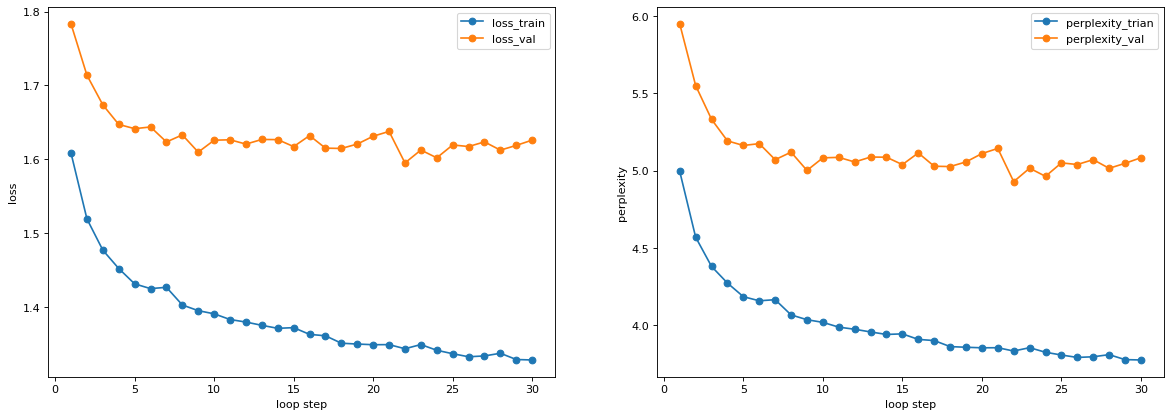

In [47]:
# total time of train is 140 mins by CPU
x = range(1,31)
fig,ax = plt.subplots(1,2,figsize=(18,6),dpi=80)

for y, label in zip([ loss_train,loss_val],
                      ['loss_train','loss_val']):
    ax[0].plot(x, y, 'o-',label=label)
ax[0].legend()
ax[0].set_xlabel('loop step')
ax[0].set_ylabel('loss')

for y, label in zip([perplexity_train, perplexity_val,],
                      ['perplexity_trian', 'perplexity_val',]):
    ax[1].plot(x, y,'o-', label=label)
ax[1].legend()
ax[1].set_xlabel('loop step')
ax[1].set_ylabel('perplexity')
plt.show()

2. Run the same training loop but modify one of the hyperparameters from this list:

In [11]:
# hyperparameters
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 8 # n_layer:4->[8]->6->2->1 run 4 times

In [12]:
model2 = LanguageModel().to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [13]:
loss_train2 = []
loss_val2 = []
perplexity_train2 = []
perplexity_val2 =[]


#train
epochs = 30
for epoch in range(epochs):
   with tqdm(total=train_iters, position=0, leave=True, desc=f"Train Epoch {epoch}") as train_bar:
        train_one_step(model2, optimizer, train_bar)

   with tqdm(total=2*eval_iters, position=0, leave=True, desc=f"Validate Epoch {epoch}") as val_bar:
        out = estimate_loss(model2,val_bar)
        print(f"Epoch {epoch}: train_loss: {out['train'].item():.3f}, validation loss: {out['val'].item():.3f})")
        print(f"Epoch {epoch}: train_perplexity: {torch.exp(out['train']).item():.3f}, validation perplexity: {torch.exp(out['val']).item():.3f})")

        loss_train2.append(out['train'].item())
        loss_val2.append(out['val'].item())
        perplexity_train2.append(torch.exp(out['train']).item())
        perplexity_val2.append(torch.exp(out['val']).item())

Train Epoch 0:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 0:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0: train_loss: 1.604, validation loss: 1.780)
Epoch 0: train_perplexity: 4.973, validation perplexity: 5.932)


Train Epoch 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1: train_loss: 1.511, validation loss: 1.700)
Epoch 1: train_perplexity: 4.532, validation perplexity: 5.473)


Train Epoch 2:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 2: train_loss: 1.455, validation loss: 1.673)
Epoch 2: train_perplexity: 4.286, validation perplexity: 5.326)


Train Epoch 3:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 3: train_loss: 1.421, validation loss: 1.640)
Epoch 3: train_perplexity: 4.141, validation perplexity: 5.156)


Train Epoch 4:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 4: train_loss: 1.401, validation loss: 1.622)
Epoch 4: train_perplexity: 4.060, validation perplexity: 5.062)


Train Epoch 5:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 5:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 5: train_loss: 1.389, validation loss: 1.618)
Epoch 5: train_perplexity: 4.012, validation perplexity: 5.044)


Train Epoch 6:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 6: train_loss: 1.364, validation loss: 1.615)
Epoch 6: train_perplexity: 3.913, validation perplexity: 5.028)


Train Epoch 7:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 7: train_loss: 1.365, validation loss: 1.624)
Epoch 7: train_perplexity: 3.915, validation perplexity: 5.071)


Train Epoch 8:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 8: train_loss: 1.344, validation loss: 1.617)
Epoch 8: train_perplexity: 3.836, validation perplexity: 5.038)


Train Epoch 9:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 9: train_loss: 1.340, validation loss: 1.616)
Epoch 9: train_perplexity: 3.818, validation perplexity: 5.032)


Train Epoch 10:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 10:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 10: train_loss: 1.337, validation loss: 1.632)
Epoch 10: train_perplexity: 3.809, validation perplexity: 5.113)


Train Epoch 11:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 11: train_loss: 1.322, validation loss: 1.632)
Epoch 11: train_perplexity: 3.749, validation perplexity: 5.115)


Train Epoch 12:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 12: train_loss: 1.325, validation loss: 1.609)
Epoch 12: train_perplexity: 3.761, validation perplexity: 4.999)


Train Epoch 13:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 13: train_loss: 1.297, validation loss: 1.619)
Epoch 13: train_perplexity: 3.659, validation perplexity: 5.049)


Train Epoch 14:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 14: train_loss: 1.306, validation loss: 1.617)
Epoch 14: train_perplexity: 3.692, validation perplexity: 5.039)


Train Epoch 15:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 15:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 15: train_loss: 1.298, validation loss: 1.647)
Epoch 15: train_perplexity: 3.662, validation perplexity: 5.189)


Train Epoch 16:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 16: train_loss: 1.291, validation loss: 1.618)
Epoch 16: train_perplexity: 3.638, validation perplexity: 5.044)


Train Epoch 17:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 17: train_loss: 1.282, validation loss: 1.594)
Epoch 17: train_perplexity: 3.603, validation perplexity: 4.926)


Train Epoch 18:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 18: train_loss: 1.284, validation loss: 1.627)
Epoch 18: train_perplexity: 3.612, validation perplexity: 5.087)


Train Epoch 19:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 19: train_loss: 1.274, validation loss: 1.619)
Epoch 19: train_perplexity: 3.576, validation perplexity: 5.047)


Train Epoch 20:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 20:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 20: train_loss: 1.273, validation loss: 1.630)
Epoch 20: train_perplexity: 3.571, validation perplexity: 5.103)


Train Epoch 21:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 21: train_loss: 1.273, validation loss: 1.625)
Epoch 21: train_perplexity: 3.570, validation perplexity: 5.078)


Train Epoch 22:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 22: train_loss: 1.266, validation loss: 1.642)
Epoch 22: train_perplexity: 3.546, validation perplexity: 5.165)


Train Epoch 23:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 23: train_loss: 1.261, validation loss: 1.645)
Epoch 23: train_perplexity: 3.528, validation perplexity: 5.181)


Train Epoch 24:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 24: train_loss: 1.258, validation loss: 1.642)
Epoch 24: train_perplexity: 3.519, validation perplexity: 5.168)


Train Epoch 25:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 25:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 25: train_loss: 1.252, validation loss: 1.643)
Epoch 25: train_perplexity: 3.496, validation perplexity: 5.173)


Train Epoch 26:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 26: train_loss: 1.245, validation loss: 1.646)
Epoch 26: train_perplexity: 3.474, validation perplexity: 5.185)


Train Epoch 27:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 27: train_loss: 1.239, validation loss: 1.629)
Epoch 27: train_perplexity: 3.453, validation perplexity: 5.100)


Train Epoch 28:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 28: train_loss: 1.240, validation loss: 1.653)
Epoch 28: train_perplexity: 3.454, validation perplexity: 5.222)


Train Epoch 29:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 29: train_loss: 1.229, validation loss: 1.648)
Epoch 29: train_perplexity: 3.419, validation perplexity: 5.197)


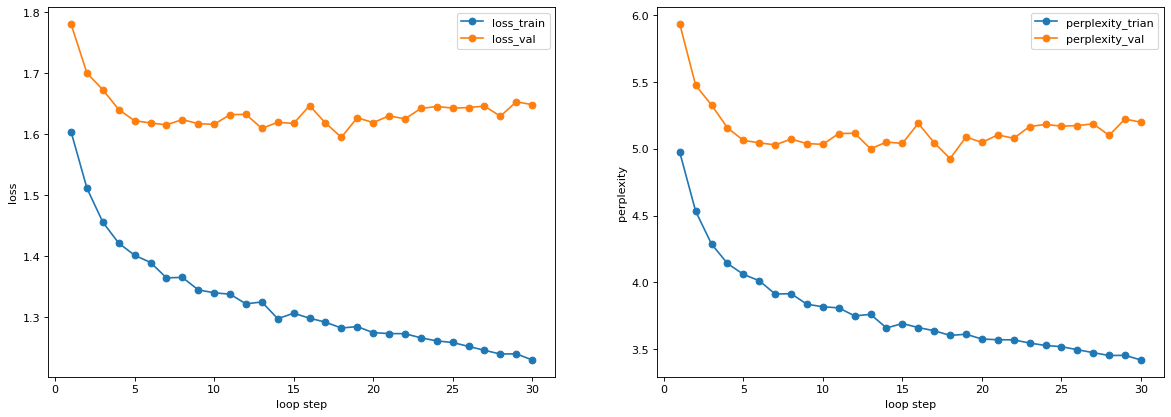

In [14]:
# total time of train is 400 mins by CPU
x = range(1,31)
fig,ax = plt.subplots(1,2,figsize=(18,6),dpi=80)

for y, label in zip([ loss_train2,loss_val2],
                      ['loss_train','loss_val']):
    ax[0].plot(x, y, 'o-',label=label)
ax[0].legend()
ax[0].set_xlabel('loop step')
ax[0].set_ylabel('loss')

for y, label in zip([perplexity_train2, perplexity_val2,],
                      ['perplexity_trian', 'perplexity_val',]):
    ax[1].plot(x, y,'o-', label=label)
ax[1].legend()
ax[1].set_xlabel('loop step')
ax[1].set_ylabel('perplexity')
plt.show()

Run this at least 4 times with a different value and plot each perplexity over training step. Write a sentence on how the perplexity changed.

In [15]:
# hyperparameters
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 6 # n_layer:4->8->[6]->2->1 run 4 times

In [16]:
model3 = LanguageModel().to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=learning_rate)

In [ ]:
loss_train3 = []
loss_val3 = []
perplexity_train3 = []
perplexity_val3 =[]


#train
epochs = 30
for epoch in range(epochs):
   with tqdm(total=train_iters, position=0, leave=True, desc=f"Train Epoch {epoch}") as train_bar:
        train_one_step(model3, optimizer, train_bar)

   with tqdm(total=2*eval_iters, position=0, leave=True, desc=f"Validate Epoch {epoch}") as val_bar:
        out = estimate_loss(model3,val_bar)
        print(f"Epoch {epoch}: train_loss: {out['train'].item():.3f}, validation loss: {out['val'].item():.3f})")
        print(f"Epoch {epoch}: train_perplexity: {torch.exp(out['train']).item():.3f}, validation perplexity: {torch.exp(out['val']).item():.3f})")

        loss_train3.append(out['train'].item())
        loss_val3.append(out['val'].item())
        perplexity_train3.append(torch.exp(out['train']).item())
        perplexity_val3.append(torch.exp(out['val']).item())

Train Epoch 0:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 0:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 0: train_loss: 1.641, validation loss: 1.793)
Epoch 0: train_perplexity: 5.162, validation perplexity: 6.008)


Train Epoch 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1: train_loss: 1.523, validation loss: 1.713)
Epoch 1: train_perplexity: 4.587, validation perplexity: 5.545)


Train Epoch 2:   0%|          | 0/5000 [00:00<?, ?it/s]

Bonus 1: output some generated text from each model you trained. Did the output make more sense with some hyperparameters than others?

Bonus 2: We saw a cool visualization of attention mechanisms with BertViz. Take a more complicated model than GPT2 such as "meta-llama/Llama-2-7b-chat-hf" and see how the attention mechanisms are different

In [ ]:
# Due to the meta model need authorization, so we have to login in the huggingface
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
from transformers import AutoTokenizer, AutoModel, utils, AutoModelForCausalLM
from bertviz import model_view
# utils.logging.set_verbosity_error()  # Suppress standard warnings

# model_name = 'batterydata/batterybert-uncased'
model_name = 'meta-llama/Llama-2-7b-chat-hf'
input_text = "No, I am your father"
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
inputs = tokenizer.encode(input_text, return_tensors='pt')  # Tokenize input text
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens)  # Display model view

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## References

Here are some recommendations for further reading and additional code for review.

* "The Illustrated Transformer" by Jay Alammar
* "Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)"
* "The Illustrated GPT-2 (Visualizing Transformer Language Models)"
* "A gentle introduction to positional encoding"
* "LLM Tutorial Workshop (Argonne National Laboratory)"
* "LLM Tutorial Workshop Part 2 (Argonne National Laboratory)"